# Assignment

In [1]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

from chess_vis import * # helper functions for visualization

import pandas as pd


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [2]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## OOD Neural Network Implementation

Implement the forward-feed mechanism and the back-propagation of an one-hidden layer neural network in object oriented fashion

In [3]:
# OOD ANN implementation
class ANN: # ANN object w/ 1 hidden layer w/ 200 units by default
    
    def __init__(self, N_in = 58, N_a = 32, random_seed = 9, act1 = 'Relu', act2 = 'Relu'): # constructor w/ the size of input, the size of output and random_seed as optional parameters
        self.N_h=200                ## NUMBER OF HIDDEN NODES (A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200)

        ### Random seed
        np.random.seed(random_seed)

        ### Xavier initialization
        self.W1 = np.random.randn(self.N_h, N_in) * np.sqrt(1 / (N_in)) # input layer, of shape (200, 58)
        self.W2 = np.random.randn(N_a, self.N_h) * np.sqrt(1 / (self.N_h)) # hidden layer, of shape (32, 200)

        self.b1 = np.zeros((self.N_h,)) # of size 200
        self.b2 = np.zeros((N_a,)) # of size 32

        ### Parameterize the choices of activation functions
        self.act1 = 1 if act1 == 'Relu' else 2
        self.act2 = 1 if act2 == 'Relu' else 2
        self.act2 = 3 if act2 == 'Sigmoid' else self.act2

        ### Initiate neurons and activations
        self.z1 = np.zeros((self.N_h,))
        self.a1 = np.zeros((self.N_h,))
        self.z2 = np.zeros((N_a,))
        self.a2 = np.zeros((N_a,))

    def forwardfeed(self, X):
        ## Forwardfeed
        ## input -> hidden
        self.z1 = self.W1 @ X + self.b1 # of size 200
        
        self.a1 = self.relu(self.z1) if self.act1 == 1 else self.z1

        ## hidden -> output
        self.z2 = self.W2 @ self.a1 + self.b2 # of size 32
        
        self.a2 = self.relu(self.z2) if self.act2 == 1 else self.z2 # of size 32
        return self.a2

    def relu(self, x): # rectified linear unit activation to cope w/ vanishing gradient
        return (x > 0).astype(int) * x 

    def backpropagation(self, X, delta, a_agent, eta):
        ## Backpropagation
        ## Gradients
        dz1, dz2 = self.calc_gradient(delta, a_agent)
        
        ## Descent (update)
        self.W2[a_agent, :] = self.W2[a_agent, :] + eta * dz2  * self.a1
        self.b2[a_agent] = self.b2[a_agent] + eta * dz2

        self.W1 = self.W1 + eta * np.outer(dz1, X)
        self.b1 = self.b1 + eta * dz1

        return self.W1, self.W2

    def calc_gradient(self, delta, a_agent):
        ## Gradients
        dz2 = delta * self.heavy_side(self.a2[a_agent]) if self.act2 == 1 else delta # of size 1

        dz1 = delta * self.W2[a_agent, :] * self.heavy_side(self.a1) if self.act1 == 1 else dz2 * self.W2[a_agent, :] * self.a1 # of size 200
        return dz1, dz2
    

    def heavy_side(self, x): # pseudo derivative of ReLu
        return (x > 0).astype(int)

    def load_weights(self, W1, W2, b1, b2): # load trained model
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1.flatten()
        self.b2 = b2.flatten()


In [4]:
# define e-greedy policy, given a list of Q-values and a scalar \epsilon
def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_class= np.shape(Qvalues)[0] # find the # of elements in the vector of Q values

    rand_values=np.random.uniform(0,1) # pick a random number from a uniform distribution of [0, 1]

    rand_a=rand_values<epsilon # bool indicator if the chosen r.v. is smaller than given epsilon w/ p = epsilon

    a= np.zeros(N_class) # prepare an output vector of size N_class

    if rand_a==True: # Random exploration

        a[np.random.randint(0,N_class)]=1 # assign 1 to a random action uniformly 

    else: # Greedy

        a[np.argmax(Qvalues)]=1 # assign 1 to the action w/ highest Q value
    
    return a.astype(bool)


## Main reinforcement learning logics

In [5]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()

N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES (A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200)


## INITALISE YOUR NEURAL NETWORK...

# nn = ANN()


# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES (Performance Measures)
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])



### Training loop of SARSA

#### Grid search for hyperparameters

| Hyper-parameter 	| Candidate1 	| Candidate2 	| Candidate3 	| Candidate4 	|
|-----------------	|------------	|------------	|------------	|------------	|
| Beta            	| 5e-07      	| 3e-05     	| 5e-05      	| 7e-05      	|
| Gamma           	| 0.2        	| 0.85       	| 0.95       	|


In [6]:
# TRAINING LOOP BONE STRUCTURE...

# Grid-search for hyperparameters
beta_list = [5e-07, 3e-05, 5e-05, 7e-05]      # Decay factor of EPSILON

gamma_list = [0.2, 0.85, 0.99]        # THE DISCOUNT FACTOR

performance = []

for beta in beta_list:

    for gamma in gamma_list:

        # SAVING VARIABLES
        R_save = np.zeros([N_episodes, 1])
        N_moves_save = np.zeros([N_episodes, 1])

        # instantiate an ANN object
        nn = ANN()

        for n in range(N_episodes):

            epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
            Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
            i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
            
            S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME

            # Choose action A (w/o taking it actually)
            ## pre-action meditation
            a,_=np.where(allowed_a==1) # find allowed actions
            
            ## find Q-values
            Qvalues = nn.forwardfeed(X) # generate a vector of estimated Q values by ANN
            Qvalues_of_allowed_a = Qvalues[a] # select only the Q values of allowed actions

            ## Given Q-values, pick an action in an e-Greedy way
            a_agent = a[EpsilonGreedy_Policy(Qvalues_of_allowed_a, epsilon_f)][0] # idx of the chosen action

            q = np.copy(Qvalues[a_agent]) # copy the Q value of the chosen action

            while Done==0:                           ## START THE EPISODE

                # take the action A & observe
                S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
                
                ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
                if Done==1:
                    
                    # Record the reward and moves taken
                    R_save[n]=np.copy(R)
                    N_moves_save[n]=np.copy(i)
                    
                    # Update Weights
                    ## Backpropagation
                    delta = (R - q) # Compute the delta
                    nn.backpropagation(X, delta, a_agent, eta) # backpropagation via gradient descent

                    break
                    
                else:
                    # post-action reflection (choose the next action w/o actually taking it either)
                    a_next,_=np.where(allowed_a_next==1) # find allowed actions

                    # Find Qvalues
                    Qvalues_next = nn.forwardfeed(X_next) # generate a vector of estimated Q values by ANN

                    Qvalues_of_allowed_a_next = Qvalues_next[a_next] # select only the Q values of allowed actions 

                    a_agent_next = a_next[EpsilonGreedy_Policy(Qvalues_of_allowed_a_next, epsilon_f)][0] # idx of the chosen action

                    q_new = np.copy(Qvalues_next[a_agent_next]) # copy the Q value of the chosen action
                    
                    # Update Weights
                    ## Backpropagation
                    
                    delta = (R + gamma * q_new - q) # Compute the delta

                    nn.backpropagation(X, delta, a_agent, eta) # backpropagation via gradient descent
                    

                # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S=np.copy(S_next)
                X=np.copy(X_next)
                allowed_a=np.copy(allowed_a_next)
                a_agent = np.copy(a_agent_next)
                q = np.copy(q_new)
                
                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

            print_progress(n, N_episodes) # odometer to show training process

        print_progress(None, N_episodes) # indicate whether training is over

        pd.DataFrame(R_save).to_csv(f'R_save_w_beta_{beta}_gamma_{gamma}_100k.csv')

        pd.DataFrame(N_moves_save).to_csv(f'N_moves_save_w_beta_{beta}_gamma_{gamma}_100k.csv')

        print('e-Greedy agent w/ SARSA and Beta = ', beta, 'Gamma = ', gamma, 'Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))

        performance.append([beta, gamma, np.mean(R_save), np.mean(N_moves_save)])

e-Greedy agent w/ SARSA and Beta =  3e-05 Gamma =  0.85 Average reward: 0.91327 Number of steps:  3.4468
e-Greedy agent w/ SARSA and Beta =  3e-05 Gamma =  0.99 Average reward: 0.91568 Number of steps:  4.75111


In [2]:
# Save the performance metrics of hyper-parameter tuning
hyper_perf = pd.DataFrame(performance, columns = ['Beta', 'Gamma', 'Avg training reward', 'Average moves per game in training'])

hyper_perf.to_csv('HP_metrics.csv')

In [6]:
hyper_perf.sort_values(by = ['Avg training reward', 'Average moves per game in training'], ascending = False)

,Beta,Gamma,Avg training reward,Average moves per game in training
11,7.000000e-05,0.99,0.93943,4.50880
8,5.000000e-05,0.99,0.93120,4.67379
7,5.000000e-05,0.85,0.92779,3.54345
10,7.000000e-05,0.85,0.92727,3.29542
5,3.000000e-05,0.99,0.91568,4.75111
4,3.000000e-05,0.85,0.91327,3.44680
2,5.000000e-07,0.99,0.85712,5.20164
1,5.000000e-07,0.85,0.85704,3.92188
0,5.000000e-07,0.20,0.62814,6.52982
3,3.000000e-05,0.20,0.61604,12.34083


## Performance metrics of hyper-parameter tuning

In [4]:
# load the results
# hyperparameters
beta_list = [5e-07, 3e-05, 5e-05, 7e-05]      # Decay factor of EPSILON

gamma_list = [0.2, 0.85, 0.99]        # THE DISCOUNT FACTOR

performance = [] # performance metrics

for beta in beta_list:
    for gamma in gamma_list:
        R_save = pd.read_csv(f'R_save_w_beta_{beta}_gamma_{gamma}_100k.csv').to_numpy()[:, 1]

        R_moves_save = pd.read_csv(f'N_moves_save_w_beta_{beta}_gamma_{gamma}_100k.csv').to_numpy()[:, 1]

        performance.append([beta, gamma, np.mean(R_save), np.mean(R_moves_save)])

performance = np.array(performance)

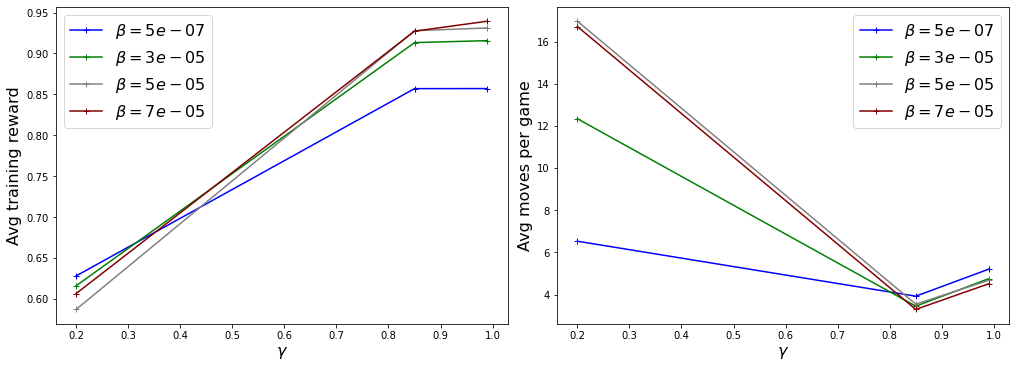

In [14]:
# visualize the performance of hyper-parameter combinations
colors = ['blue', 'green', 'grey', 'maroon']
ys = ['Avg training reward', 'Avg moves per game']


fig, ax = plt.subplots(1, 2, figsize = (14 , 5), constrained_layout = True)
for i in range(2):
    for j in range(len(beta_list)):
        temp_perf = performance[performance[:, 0] == beta_list[j]]
        ax[i].plot(temp_perf[:, 1], temp_perf[:, 2 + i], '+-', color = colors[j], label = f"$\\beta = {beta_list[j]}$")
        ax[i].set_xlabel(r'$\gamma$ ', fontsize = 16)
        ax[i].set_ylabel(ys[i], fontsize = 16)
        ax[i].legend(fontsize = 16)